## Install

In [1]:
%pip install -q py7zr
%pip install -q xmltodict
%pip install -q imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [2]:
import os
import zipfile
import pandas
import py7zr
import glob
import xmltodict
import json

## Data acquisition

## Pre processing

In [3]:
from functools import reduce
from unicodedata import normalize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('portuguese'))
word_net_lemmatizer = WordNetLemmatizer()

def remove_accent_diacritic(text: str):
  return normalize('NFKD', text)
    
def remove_special_char(text: str):
  def internal():
    for character in text:
      if character.isalnum() or character.isspace():
        yield character
  return ''.join(internal())

def remove_stop_words(text: str):
  words = word_tokenize(text)
  return list(filter(lambda x: x not in stop_words, words))

def lemmatize_text(text: str):
  return ' '.join(map(word_net_lemmatizer.lemmatize, text))

steps = [
  str.lower,
  remove_accent_diacritic,
  remove_special_char,
  remove_stop_words,
  lemmatize_text,
]

def process_description(text):
  return reduce(lambda result, func: func(result), steps, text)

def pre_processing(df: pandas.DataFrame):
  total_rows = len(df)

  df.drop_duplicates(inplace=True)
  # Remove the lines where the quantity purchased has decimal places, which indicates that the product was not manufactured in an industry, but is sold in bulk.
  df = df[df['quantity'] % 1 == 0]
  
  df.info() 

  unique_rows = len(df)
  removed_rows = total_rows - unique_rows
  print(f'Total rows: {total_rows}')
  print(f'Unique rows: {unique_rows}')
  print(f'Removed rows: {removed_rows}')
  print(f'Removed rows percentage: {round(removed_rows / total_rows * 100, 2)}%')
  return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\teichx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\teichx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data to classify

In [4]:
def get_class_items():
  folder_path = '../data/raw'
  processed_files = 0
  for file_name in os.listdir(folder_path):
    if not file_name.endswith('.zip'):
      continue
    zip_path = os.path.join(folder_path, file_name)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      file_items_name = f'{file_name.removesuffix('.zip')}_NotaFiscalItem.csv'
      with zip_ref.open(file_items_name) as file:
        file.seek(0)
        data_frame = pandas.read_csv(file, delimiter=';', encoding='latin1')
        data_frame.rename(columns={
          'CHAVE DE ACESSO': 'access_key',
          'DATA EMISSÃO': 'emission_date',
          'CPF/CNPJ Emitente': 'emission_owner',
          'NÚMERO PRODUTO': 'product_index',
          'DESCRIÇÃO DO PRODUTO/SERVIÇO': 'description',
          'CÓDIGO NCM/SH': 'ncm',
          'NCM/SH (TIPO DE PRODUTO)': 'ncm_description',
          'CFOP': 'cfop',
          'QUANTIDADE': 'quantity',
          'UNIDADE': 'unit_kind',
          'VALOR UNITÁRIO': 'unitary_value',
          'VALOR TOTAL': 'total_value',
        }, inplace=True)
        selected_fields = data_frame \
          .loc[:, [
            'access_key',
            'emission_date',
            'emission_owner',
            'product_index',
            'description',
            'ncm',
            'ncm_description',
            'cfop',
            'quantity',
            'unit_kind',
            'unitary_value',
            'total_value',
          ]]
        selected_fields['quantity'] = selected_fields['quantity'].str.replace(',', '.')
        selected_fields['total_value'] = selected_fields['total_value'].str.replace(',', '.')
        selected_fields['unitary_value'] = selected_fields['unitary_value'].str.replace(',', '.')
        selected_fields['processed_description'] = selected_fields['description'].apply(process_description)

        yield selected_fields \
          .astype({
            'access_key': 'str',
            'emission_date': 'datetime64[ms]',
            'emission_owner': 'str',
            'product_index': 'int32',
            'description': 'str',
            'processed_description': 'str',
            'ncm': 'str',
            'ncm_description': 'str',
            'cfop': 'str',
            'quantity': 'float64',
            'unit_kind': 'str',
            'unitary_value': 'float64',
            'total_value': 'float64',
          })
        processed_files += 1
        print(f'Processed files {processed_files}')


def get_class_combined():
  combined_path = '../data/combined.parquet.br'
  if os.path.exists(combined_path):
    print('Reading cache combined data')
    return pandas.read_parquet(combined_path)
  combined_data = pandas.concat(get_class_items(), ignore_index=True)
  print('Start pre-processing')
  processed_data = pre_processing(combined_data)
  print('End pre-processing')
  print('Start compression')
  processed_data.to_parquet(combined_path, index=False, compression='brotli')
  print('End compression')
  return processed_data

data_frame = get_class_combined()

Reading cache combined data


#### Analyze dataset

In [5]:
table = dict(map(lambda x: (str(x), {'unique': 0}), range(0, 100)))
for table_item in data_frame['access_key'].unique():
  table[table_item[0:2]]['unique'] += 1
  
table = dict(filter(lambda x: x[1]['unique'] > 0, table.items()))
for key in table.keys():
  current_state = data_frame.where(data_frame['access_key'].str.startswith(key))
  total_value = current_state['total_value']
  table[key] |= {
    'total': total_value.count(),
    'total_value': round(total_value.sum(), 2),
  }

In [6]:
# Acquired from 'https://servicodados.ibge.gov.br/api/v1/localidades/estados' 2024-10-27T10:24:00-03:00
with open('../data/br_states.json', encoding='utf8') as file:
  states_json = json.loads(file.read())
  state_codes = dict(map(lambda x: (str(x['id']), x), states_json))

In [7]:
meta_table_rows = list(table.items())
meta_table_rows.sort(key=lambda x: x[1]['total'], reverse=True)
meta_data_table = pandas.DataFrame(
  data=map(lambda x: {
    'UF': state_codes.get(x[0])['sigla'],
    'State': state_codes.get(x[0])['nome'],
    'Unique invoices': x[1]['unique'],
    'Product rows': x[1]['total'],
    'Total amount': x[1]['total_value'],
  }, meta_table_rows), 
)
print(meta_data_table)

    UF                State  Unique invoices  Product rows  Total amount
0   SP            São Paulo           958658       4347276  9.930479e+10
1   RJ       Rio de Janeiro           753427       2428270  4.477481e+10
2   RS    Rio Grande do Sul           402972       1871396  5.318799e+09
3   MG         Minas Gerais           331109       1222405  1.789578e+10
4   DF     Distrito Federal           376974       1036455  1.515608e+10
5   PR               Paraná           257581        920613  8.389014e+09
6   SC       Santa Catarina           213615        553848  5.367721e+09
7   PE           Pernambuco           141205        477757  6.922940e+09
8   MS   Mato Grosso do Sul            88916        414219  9.358505e+08
9   BA                Bahia           107064        413975  1.460084e+09
10  PA                 Pará            97942        391397  9.696880e+08
11  AM             Amazonas            96810        384924  1.309225e+09
12  RN  Rio Grande do Norte            94481       

##### Unique NCMs

In [8]:
len(set(data_frame.ncm))

10129

##### NCM histogram

In [9]:
ncm_counts = data_frame.ncm.value_counts()

In [10]:
counter = ncm_counts.values.tolist()

In [11]:
ncm_counts

ncm
49019900    2276341
90189099     623195
90211020     469306
-1           389747
90213190     193870
             ...   
29331911          1
72023000          1
85088091          1
97810521          1
84652000          1
Name: count, Length: 10129, dtype: int64

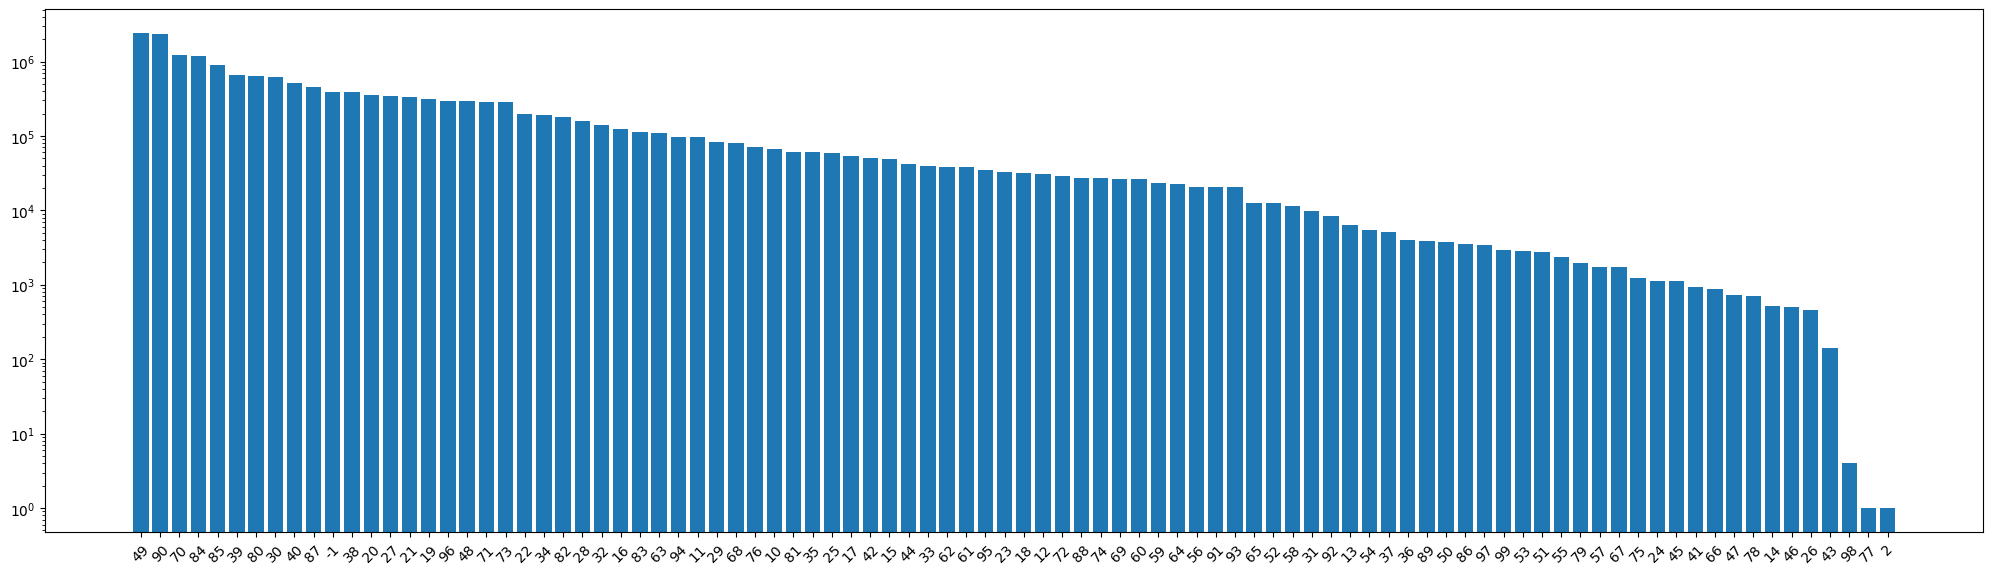

In [12]:
from matplotlib import pyplot

ncm_counts = data_frame.ncm.str[:2].value_counts()

pyplot.figure(figsize=(20, 6))
pyplot.bar(ncm_counts.index, ncm_counts.values)
pyplot.xticks(rotation=45) 
pyplot.tight_layout()
pyplot.yscale('log')
pyplot.show()

In [13]:
filtered_df = data_frame[data_frame.ncm != '-1']
min_df = pandas.DataFrame({
  'ncm_prefix': filtered_df.ncm.str[:2],
  'processed_description': filtered_df.processed_description,
})

In [14]:
rows_before_remove_duplicates = len(min_df)
min_df.drop_duplicates(inplace=True)
rows_after_remove_duplicates = len(min_df)
print('Rows duplicate removed: ' + str(rows_before_remove_duplicates - rows_after_remove_duplicates))

Rows duplicate removed: 13408177


In [15]:
from imblearn.under_sampling import RandomUnderSampler


In [16]:
RandomUnderSampler(random_state=42)

RandomUnderSampler(random_state=42)

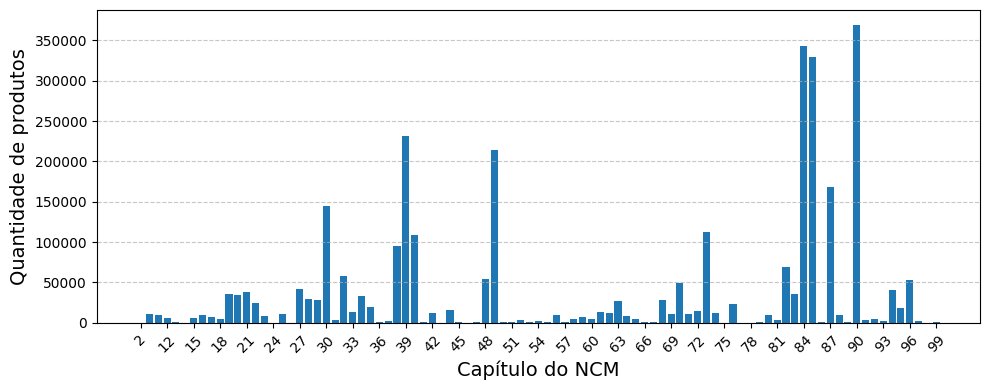

In [48]:
ncm_counts_class_data = min_df.ncm_prefix.value_counts()
ncm_counts_class_data = ncm_counts_class_data.sort_index(key=lambda x: x.astype(int)) 


pyplot.figure(figsize=(10, 4)) 
pyplot.bar(ncm_counts_class_data.index, ncm_counts_class_data.values, width=0.8) 
pyplot.xticks(ticks=ncm_counts_class_data.index[::3], labels=ncm_counts_class_data.index[::3], rotation=45)
pyplot.grid(axis='y', linestyle='--', alpha=0.7)
pyplot.xlabel('Capítulo do NCM', fontsize=14)
pyplot.ylabel('Quantidade de produtos', fontsize=14)

pyplot.tight_layout()

pyplot.show()

### Classes data

In [18]:
def get_class_items():
  folder_path = '../data/tce_rs'
  processed_files = 0
  for file_name in os.listdir(folder_path):
    if not file_name.endswith('.xml.7z'):
      continue
    zip_path = os.path.join(folder_path, file_name)
    
    with py7zr.SevenZipFile(zip_path, mode='r') as zip_ref:
      zip_ref.extractall(folder_path)
      
  for invoice_xml in glob.glob(f'{folder_path}/**/*.xml'):
    processed_files += 1
    with open(invoice_xml, 'r', encoding='utf-8') as file:
      data = xmltodict.parse(file.read())
      products = data.get('nfeProc', {}).get('NFe', {}).get('infNFe', {}).get('det', [])
      product_list = products \
        if isinstance(products, list) \
        else [products]
      
      if not product_list:
        continue
        
      access_key = data['nfeProc']['protNFe']['infProt']['chNFe']
      cnpj = data['nfeProc']['NFe']['infNFe']['emit']['CNPJ']
      emission_date = pandas.to_datetime(data['nfeProc']['NFe']['infNFe']['ide']['dhEmi']) \
        .tz_convert(None)
      for product in product_list:
        ean = product['prod']['cEAN']
        if not ean or ean == 'SEM GTIN':
          continue
        
        description = product['prod']['xProd']
        yield {
          'access_key': access_key,
          'emission_date': emission_date,
          'emission_owner': cnpj,
          'product_index': int(product['@nItem']),
          'description': description,
          'ean': ean,
          'ncm': product['prod']['NCM'],
          'cfop': product['prod']['CFOP'],
          'quantity': float(product['prod']['qCom']),
          'unit_kind': product['prod']['uCom'],
          'unitary_value': float(product['prod']['vUnCom']),
          'total_value': float(product['prod']['vProd']),
          'processed_description': process_description(description),
        }
        
    if processed_files % 100 == 0:
      print(f'Processed files: {processed_files}')

def get_class_combined():
  class_path = '../data/class.parquet.br'
  if os.path.exists(class_path):
    print('Reading cache combined data')
    return pandas.read_parquet(class_path)

  class_data = pandas.DataFrame(get_class_items()) \
    .astype({
      'access_key': 'str',
      'emission_date': 'datetime64[ms]',
      'emission_owner': 'str',
      'product_index': 'int32',
      'description': 'str',
      'ncm': 'str',
      'ean': 'str',
      'cfop': 'str',
      'quantity': 'float64',
      'unit_kind': 'str',
      'unitary_value': 'float64',
      'total_value': 'float64',
    })
  print('Start pre-processing')
  processed_data = pre_processing(class_data)
  print('End pre-processing')
  print('Start compression')
  processed_data.to_parquet(class_path, index=False, compression='brotli')
  print('End compression')
  return processed_data

class_data = get_class_combined()

Reading cache combined data


In [19]:
descriptions_dict = dict()
for row in class_data.itertuples():
  field = row.processed_description
  if not descriptions_dict.get(field):
    descriptions_dict[field] = set()
    
  item = frozenset([
    ('ncm', row.ncm),
    ('ean', row.ean),
  ])
  descriptions_dict[field].add(item)
  
for key, value in descriptions_dict.items():
  descriptions_dict[key] = list(map(dict, value))
  
with open('../data/ean_list.json', 'w') as file:
  file.write(json.dumps(descriptions_dict, indent=2))

In [20]:
len(class_data)

3560

In [21]:
len(set(class_data.ncm))

452

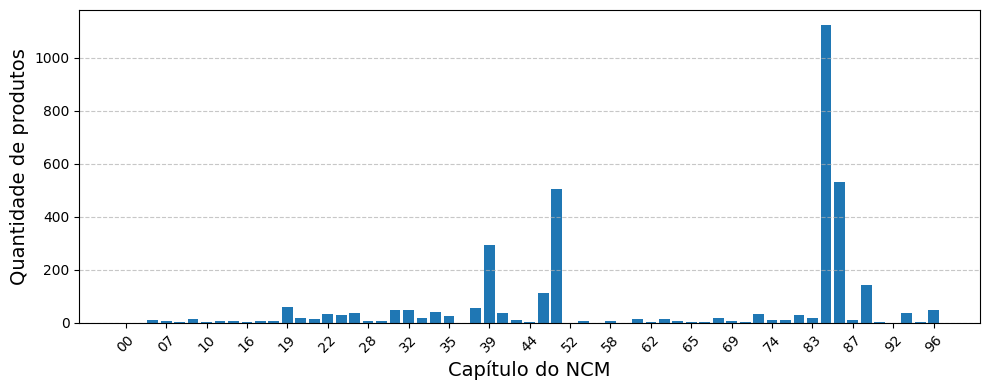

In [49]:
from matplotlib import pyplot

ncm_counts_class_data = class_data.ncm.str[:2].value_counts()
ncm_counts_class_data = ncm_counts_class_data.sort_index(key=lambda x: x.astype(int)) 


pyplot.figure(figsize=(10, 4)) 
pyplot.bar(ncm_counts_class_data.index, ncm_counts_class_data.values, width=0.8) 
pyplot.xticks(ticks=ncm_counts_class_data.index[::3], labels=ncm_counts_class_data.index[::3], rotation=45)
pyplot.grid(axis='y', linestyle='--', alpha=0.7)
pyplot.xlabel('Capítulo do NCM', fontsize=14)
pyplot.ylabel('Quantidade de produtos', fontsize=14)

pyplot.tight_layout()

pyplot.show()